# import

In [16]:
from utlis import TurboState,update_state,get_initial_points
import torch

In [17]:
import os
import math
from dataclasses import dataclass

import numpy as np
import GPy
import matplotlib.pyplot as plt
import torch
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine
from gpytorch.kernels import MaternKernel, RBFKernel, IndexKernel
from botorch.models import FixedNoiseGP, ModelListGP
from botorch.utils.transforms import normalize,unnormalize

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import HorseshoePrior
from botorch.models import FixedNoiseGP, ModelListGP

from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning

from botorch.utils.transforms import standardize
from botorch.models.transforms.input import Warp
from gpytorch.priors.torch_priors import LogNormalPrior

import warnings


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [18]:
from botorch.test_functions import Ackley
from botorch.test_functions import Beale
from botorch.test_functions import Branin
from botorch.test_functions import EggHolder
from botorch.test_functions import Hartmann
from botorch.test_functions import Griewank

# setting

In [36]:
fun = Ackley(dim=2,negate=True)
dim = fun.dim
# lb = torch.tensor([0])
# ub = torch.tensor([1])
bounds = fun.bounds

batch_size = 1
n_init = 5 * dim
max_cholesky_size = float("inf")  # Always use Cholesky

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

NUM_RESTARTS = 4*dim 
RAW_SAMPLES = 100*dim 

exp_num = 20

# Normal BO

In [37]:
BO_res = []

for N in range(exp_num):
    
    print(N)
    
    seed = N
    X_BO = get_initial_points(bounds, n_init,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)


    torch.manual_seed(seed)
    
    best = Y_BO.max()
    best_record = [best]
    

    for i in range(15*dim):  # Run until TuRBO converges
        # Fit a GP model
        train_yvar = torch.tensor(10**(-4), device=device, dtype=dtype)
        
        train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
        train_X = normalize(X_BO, bounds)
        
        covar_module = ScaleKernel(MaternKernel())
        model = FixedNoiseGP(train_X, train_Y,train_yvar.expand_as(train_Y), covar_module=covar_module)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)

        fit_gpytorch_mll(mll)

        # Create a batch
        EI = ExpectedImprovement(model=model, best_f=train_Y.max()) .to(device)   
        X_next_normalized, _ = optimize_acqf(
            acq_function=EI,
            bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,  
            q=batch_size,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            options={},
        )
        
        X_next = unnormalize(X_next_normalized, bounds)
        

        Y_next = torch.tensor(
            [fun(x) for x in X_next], dtype=dtype, device=device
        ).reshape(-1,1)

        # Append data
        X_BO = torch.cat((X_BO, X_next), dim=0)
        Y_BO = torch.cat((Y_BO, Y_next), dim=0)
        
        best_record.append(Y_BO.max())
        
    BO_res.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [31]:
bounds

tensor([[-32.7680, -32.7680],
        [ 32.7680,  32.7680]])

# TuRBO

In [21]:
TuRBO_res = []

for N in range(exp_num):
    
    print(N)
    
    seed = N
    X_turbo = get_initial_points(bounds, n_init,seed=seed)
    Y_turbo = torch.tensor(
        [fun(x) for x in X_turbo], dtype=dtype, device=device
    ).reshape(-1,1)

    state = TurboState(dim, batch_size=batch_size)


    torch.manual_seed(seed)
    
    best = Y_turbo.max()
    best_record = [best]


    for i in range(15*dim):  # Run until TuRBO converges
        # Fit a GP model
        train_yvar = torch.tensor(10**(-4), device=device, dtype=dtype)
        
        train_Y = (Y_turbo - Y_turbo.mean()) / Y_turbo.std()
        train_X = normalize(X_turbo, bounds)
        
        covar_module =     covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(
            nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0)
        )
        )
        model = FixedNoiseGP(train_X, train_Y,train_yvar.expand_as(train_Y), covar_module=covar_module)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)

        fit_gpytorch_mll(mll)
        
        
        #determine the searching area
        x_center = train_X[train_Y.argmax(), :].clone()
        weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
        weights = weights / weights.mean()
        weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
        tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
        tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)

        # Create a batch
        EI = ExpectedImprovement(model=model, best_f=train_Y.max()) .to(device)   
        X_next_normalized, _ = optimize_acqf(
            acq_function=EI,
            bounds=torch.stack([tr_lb, tr_ub]),          #torch.tensor([0.,1.]*dim).reshape(-1,2).T,  
            q=batch_size,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            options={},
        )
        
        X_next = unnormalize(X_next_normalized, bounds)
        

        Y_next = torch.tensor(
            [fun(x) for x in X_next], dtype=dtype, device=device
        ).reshape(-1,1)

        # Update state
        state = update_state(state=state, Y_next=Y_next)

        # Append data
        X_turbo = torch.cat((X_turbo, X_next), dim=0)
        Y_turbo = torch.cat((Y_turbo, Y_next), dim=0)
        
        best_record.append(Y_turbo.max())
        
    TuRBO_res.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


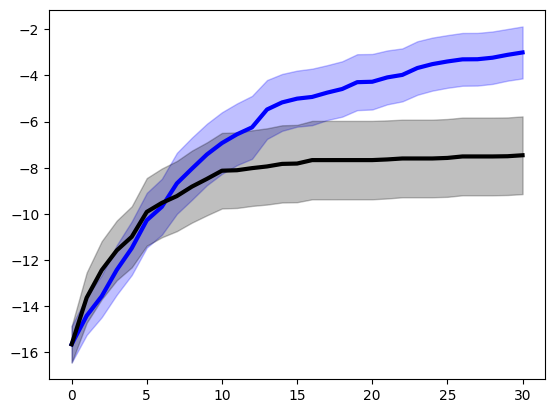

In [39]:
N = 20
total_record = np.array(TuRBO_res)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = np.array(BO_res)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

# Warping

In [56]:
# import os
# import torch


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# dtype = torch.double
# SMOKE_TEST = os.environ.get("SMOKE_TEST")

Text(0, 0.5, 'Transformed Value')

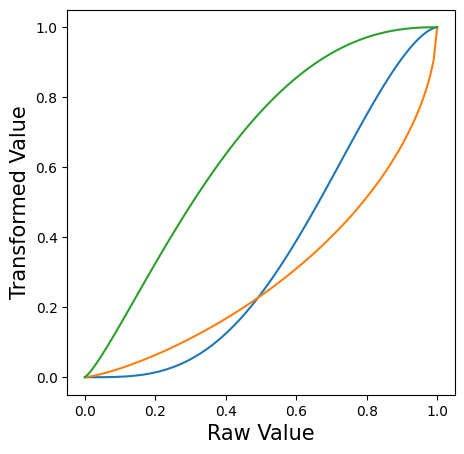

In [57]:
from torch.distributions import Kumaraswamy
import matplotlib.pyplot as plt

%matplotlib inline


fontdict = {"fontsize": 15}
torch.manual_seed(1)
c1 = torch.rand(3, dtype=dtype, device=device) * 3 + 0.1
c0 = torch.rand(3, dtype=dtype, device=device) * 3 + 0.1
x = torch.linspace(0, 1, 101, dtype=dtype, device=device)
k = Kumaraswamy(concentration1=c1, concentration0=c0)
k_icdfs = k.icdf(x.unsqueeze(1).expand(101, 3))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in range(3):
    ax.plot(x.cpu(), k_icdfs[:, i].cpu())
ax.set_xlabel("Raw Value", **fontdict)
ax.set_ylabel("Transformed Value", **fontdict)

In [58]:
from botorch.test_functions import Hartmann

neg_hartmann6 = Hartmann(dim=3,negate=True)


def obj(X):
    X_warp = X #k.icdf(X)
    return neg_hartmann6(X_warp)

In [59]:
from botorch.models import FixedNoiseGP
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.sampling import draw_sobol_samples

NOISE_SE = 10**(-2)
train_yvar = torch.tensor(NOISE_SE**2, device=device, dtype=dtype)

bounds = torch.tensor([[0.0] * 3, [1.0] * 3], device=device, dtype=dtype) #here is bound


def generate_initial_data(n=14):
    # generate training data
    train_x = draw_sobol_samples(
        bounds=bounds, n=n, q=1, seed=torch.randint(0, 10000, (1,)).item()
    ).squeeze(1)
    exact_obj = obj(train_x).unsqueeze(-1)  # add output dimension

    best_observed_value = exact_obj.max().item()
    train_obj = exact_obj #+ NOISE_SE * torch.randn_like(exact_obj)
    return train_x, train_obj, best_observed_value

In [60]:
from botorch.utils.transforms import standardize
from botorch.models.transforms.input import Warp
from gpytorch.priors.torch_priors import LogNormalPrior


def initialize_model(train_x, train_obj, use_input_warping):
    if use_input_warping:
        # initialize input_warping transformation
        warp_tf = Warp(
            indices=list(range(train_x.shape[-1])),
            # use a prior with median at 1.
            # when a=1 and b=1, the Kumaraswamy CDF is the identity function
            concentration1_prior=LogNormalPrior(0.0, 0.75**0.5),
            concentration0_prior=LogNormalPrior(0.0, 0.75**0.5),
        )
    else:
        warp_tf = None
    # define the model for objective
    model = FixedNoiseGP(
        train_x,
        standardize(train_obj),
        train_yvar.expand_as(train_obj),
        input_transform=warp_tf,
    ).to(train_x)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

In [61]:
from botorch.optim import optimize_acqf


num_restarts = 20 if not SMOKE_TEST else 2
raw_samples = 512 if not SMOKE_TEST else 32


def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=num_restarts,
        raw_samples=raw_samples,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values
    new_x = candidates.detach()
    exact_obj = obj(new_x).unsqueeze(-1)  # add output dimension
    train_obj = exact_obj  #+ NOISE_SE * torch.randn_like(exact_obj)
    return new_x, train_obj


def update_random_observations(best_random):
    """Simulates a quasi-random policy by taking a the current list of best values observed randomly,
    drawing a new random point, observing its value, and updating the list.
    """
    rand_x = draw_sobol_samples(bounds=bounds, n=1, q=1).squeeze(1)
    next_random_best = obj(rand_x).max().item()
    best_random.append(max(best_random[-1], next_random_best))
    return best_random

In [63]:
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning

import time
import warnings


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


N_TRIALS = 10 if not SMOKE_TEST else 2
N_BATCH = 50 if not SMOKE_TEST else 5

verbose = False

best_observed_all_ei, best_observed_all_warp, best_random_all = [], [], []

torch.manual_seed(0)


# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    
    seed = trial

    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_ei, best_observed_warp, best_random = [], [], []

    # call helper functions to generate initial training data and initialize model
    train_x_ei = get_initial_points(bounds, n_init,seed=seed)
    train_obj_ei = torch.tensor(
    [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)
    
    train_x_ei, train_obj_ei, best_observed_value_ei = generate_initial_data(n=14)
    mll_ei, model_ei = initialize_model(
        train_x_ei, train_obj_ei, use_input_warping=False
    )

    train_x_warp, train_obj_warp, = (
        train_x_ei,
        train_obj_ei,
    )
    best_observed_value_warp = best_observed_value_ei
    # use input warping
    mll_warp, model_warp = initialize_model(
        train_x_warp, train_obj_warp, use_input_warping=True
    )

    best_observed_ei.append(best_observed_value_ei)
    best_observed_warp.append(best_observed_value_warp)
    best_random.append(best_observed_value_ei)

    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, 30 + 1):

        t0 = time.monotonic()

        # fit the models
        fit_gpytorch_mll(mll_ei)
        fit_gpytorch_mll(mll_warp)



        ei = ExpectedImprovement(model=model_ei, best_f=best_observed_value_ei) .to(device) 

        ei_warp = ExpectedImprovement(model=model_warp, best_f=best_observed_value_warp) .to(device) 



        # optimize and get new observation
        new_x_ei, new_obj_ei = optimize_acqf_and_get_observation(ei)
        new_x_warp, new_obj_warp = optimize_acqf_and_get_observation(ei_warp)

        # update training points
        train_x_ei = torch.cat([train_x_ei, new_x_ei])
        train_obj_ei = torch.cat([train_obj_ei, new_obj_ei])

        train_x_warp = torch.cat([train_x_warp, new_x_warp])
        train_obj_warp = torch.cat([train_obj_warp, new_obj_warp])

        # update progress
        best_random = update_random_observations(best_random)
        best_value_ei = obj(train_x_ei).max().item()
        best_value_warp = obj(train_x_warp).max().item()
        best_observed_ei.append(best_value_ei)
        best_observed_warp.append(best_value_warp)

        mll_ei, model_ei = initialize_model(
            train_x_ei, train_obj_ei, use_input_warping=False
        )
        mll_warp, model_warp = initialize_model(
            train_x_warp, train_obj_warp, use_input_warping=True
        )

        t1 = time.monotonic()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, ei, ei_warp) = "
                f"({max(best_random):>4.2f}, {best_value_ei:>4.2f}, {best_value_warp:>4.2f}), "
                f"time = {t1-t0:>4.2f}.",
                end="",
            )
        else:
            print(".", end="")

    best_observed_all_ei.append(best_observed_ei)
    best_observed_all_warp.append(best_observed_warp)
    best_random_all.append(best_random)


Trial  1 of 10 ..............................
Trial  2 of 10 ..............................
Trial  3 of 10 ..............................
Trial  4 of 10 ..............................
Trial  5 of 10 ..............................
Trial  6 of 10 ..............................
Trial  7 of 10 ..............................
Trial  8 of 10 ..............................
Trial  9 of 10 ..............................
Trial 10 of 10 ..............................

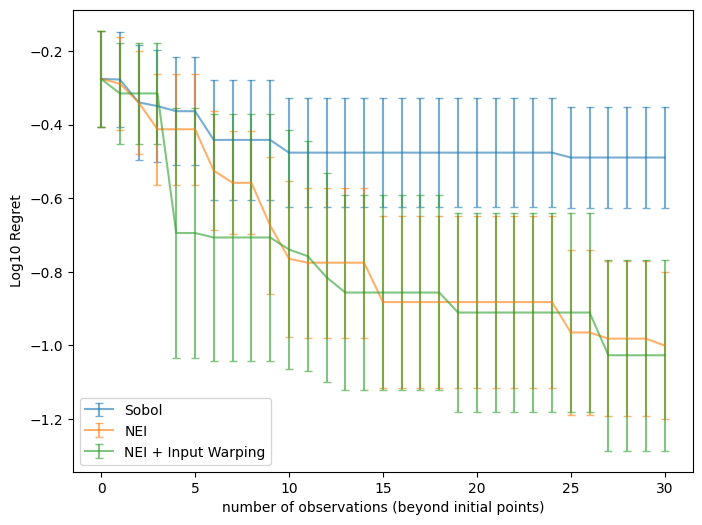

In [64]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)


GLOBAL_MAXIMUM = neg_hartmann6.optimal_value


iters = np.arange(30 + 1)
y_ei = np.log10(GLOBAL_MAXIMUM - np.asarray(best_observed_all_ei))
y_ei_warp = np.log10(GLOBAL_MAXIMUM - np.asarray(best_observed_all_warp))
y_rnd = np.log10(GLOBAL_MAXIMUM - np.asarray(best_random_all))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(
    iters,
    y_rnd.mean(axis=0),
    yerr=ci(y_rnd),
    label="Sobol",
    linewidth=1.5,
    capsize=3,
    alpha=0.6,
)
ax.errorbar(
    iters,
    y_ei.mean(axis=0),
    yerr=ci(y_ei),
    label="NEI",
    linewidth=1.5,
    capsize=3,
    alpha=0.6,
)
ax.errorbar(
    iters,
    y_ei_warp.mean(axis=0),
    yerr=ci(y_ei_warp),
    label="NEI + Input Warping",
    linewidth=1.5,
    capsize=3,
    alpha=0.6,
)
ax.set(xlabel="number of observations (beyond initial points)", ylabel="Log10 Regret")
ax.legend(loc="lower left")

In [ ]:
train_x_ei, train_obj_ei, best_observed_value_ei = generate_initial_data(n=14)

In [54]:
fun(train_x_ei)

tensor([-4.3857, -3.9969, -4.0538, -4.6848, -3.4011, -4.1408, -3.3798, -5.1346,
        -4.9598, -4.7203, -1.2211, -5.1721, -4.2847, -3.8136, -4.1475, -4.9416,
        -4.2434, -4.1523, -3.5204, -3.6027, -4.4470, -4.8112, -3.2085, -3.7862,
        -3.7720, -4.0142, -4.9346, -4.3393, -2.6317, -5.0018, -4.2654, -3.0459,
        -5.1078, -3.6223, -3.4615, -3.4579, -4.1326, -5.0530, -4.3009, -4.2421,
        -1.7681, -1.4711, -5.2500, -3.7891], dtype=torch.float64)

In [55]:
train_obj_ei

tensor([[2.1715e-01],
        [5.6692e-01],
        [1.2648e+00],
        [3.9260e-01],
        [4.3557e-01],
        [4.8026e-01],
        [1.8447e-01],
        [2.8742e+00],
        [7.7651e-01],
        [3.8043e+00],
        [7.9439e-02],
        [1.2376e+00],
        [2.1886e-01],
        [5.9073e-01],
        [2.6512e+00],
        [3.1197e+00],
        [1.7510e+00],
        [3.7481e+00],
        [2.9077e-02],
        [3.2332e-03],
        [1.3952e+00],
        [8.5845e-01],
        [2.3127e-01],
        [1.1210e-02],
        [1.4086e-02],
        [5.8671e-04],
        [1.3628e+00],
        [2.6341e-01],
        [4.7693e-02],
        [1.9959e+00],
        [3.3249e-02],
        [1.2159e-01],
        [3.5376e+00],
        [1.6464e+00],
        [1.4550e+00],
        [8.6225e-01],
        [2.9802e+00],
        [2.5122e+00],
        [2.8718e+00],
        [1.0940e-01],
        [4.8502e-01],
        [3.7467e-01],
        [2.8979e+00],
        [1.8348e+00]], dtype=torch.float64)

In [8]:
train_x_temp = get_initial_points(dim, n_init,dtype, device,seed=1)
train_obj_temp = obj(train_x_temp,k,fun).reshape(-1,1)

In [9]:
train_x_temp

tensor([[0.2677, 0.3618],
        [0.8434, 0.9918],
        [0.6499, 0.1275],
        [0.2071, 0.5073],
        [0.1179, 0.1188],
        [0.5520, 0.7464],
        [0.9877, 0.3841],
        [0.4364, 0.7624],
        [0.4843, 0.1961],
        [0.9086, 0.5754]], dtype=torch.float64)

In [10]:
train_obj_temp

tensor([[-2.8026],
        [-4.4995],
        [-2.5471],
        [-3.2463],
        [-0.6051],
        [-3.4574],
        [-4.5292],
        [-2.9110],
        [-1.7696],
        [-4.5031]], dtype=torch.float64)

In [11]:
fun(train_x_temp)

tensor([-3.2667, -3.9082, -3.4512, -3.5163, -1.0988, -4.5632, -4.3683, -4.3990,
        -3.4250, -4.5650], dtype=torch.float64)

In [13]:
train_x_warp, train_obj_warp, = (
    train_x_temp,
    train_obj_temp,
)

In [15]:
train_obj_warp

tensor([[-2.8026],
        [-4.4995],
        [-2.5471],
        [-3.2463],
        [-0.6051],
        [-3.4574],
        [-4.5292],
        [-2.9110],
        [-1.7696],
        [-4.5031]], dtype=torch.float64)